In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
df = pd.read_csv(r'C:\Users\allur\OneDrive\Desktop\project\customer_churn_sample_3000.csv')
print("shape:",df.shape)
print("\nColumns:",df.columns)
df.head()
print("data types:\n",df.dtypes)
print("\nMissing values:\n",df.isnull().sum())
print("\n precentage of missing data:\n",(df.isnull().mean()*100).round(2))
missing = df.isnull().sum()
missing = missing[missing > 0]
print("Columns with missing values:\n", missing)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].dtype)
df.drop('customerID', axis=1, inplace=True)
print("\nFinal shape after dropping customerID:", df.shape)






shape: (3000, 21)

Columns: Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn             

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
import joblib, os
import numpy as np
import pandas as pd
TARGET = 'Churn'
if TARGET not in df.columns:
    raise ValueError("column 'Churn' not found in the DataFrame. check your data.")
y= df[TARGET].map({'Yes': 1, 'No': 0})
if y.isna().any():
    print("unique 'chrun' values:", df[TARGET].unique())
    raise ValueError("target mapping creating NaNs. Adjust the mapping above.")
num_cols = df.select_dtypes(include=[np.number]).columns.drop(TARGET, errors='ignore').tolist()
cat_cols = [c for c in df.columns if c not in num_cols + [TARGET]]
print(f"numeric features ({len(num_cols)}): {num_cols}")
print(f"categorical features ({len(cat_cols)}): {cat_cols}")
X = df[num_cols + cat_cols]
X_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
x_valid, X_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
print("shapes - train:", X_train.shape, "valid:", x_valid.shape, "test:", X_test.shape)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
try:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
except TypeError:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ("ohe", OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)
clf= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=300))
])
clf.fit(X_train, y_train)
y_pred  = clf.predict(x_valid)
y_proba = clf.predict_proba(x_valid)[:, 1]
print("\n=== validation metrics ===")
print("accuracy:", round(accuracy_score(y_valid, y_pred), 4))
print("f1 score:", round(f1_score(y_valid, y_pred), 4))
print("roc auc score:", round(roc_auc_score(y_valid, y_proba), 4))
print("\nClassification report:\n", classification_report(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred)
os.makedirs('models', exist_ok=True)
model_path = os.path.join('models', 'baseline_logreg_pipeline.joblib')
joblib.dump(clf, model_path)
print(f"\nSaved model to: {model_path}")





numeric features (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
categorical features (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
shapes - train: (2100, 19) valid: (450, 19) test: (450, 19)

=== validation metrics ===
accuracy: 0.5244
f1 score: 0.5368
roc auc score: 0.5152

Classification report:
               precision    recall  f1-score   support

           0       0.53      0.50      0.51       225
           1       0.52      0.55      0.54       225

    accuracy                           0.52       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.52      0.52      0.52       450


Saved model to: models\baseline_logreg_pipeline.joblib



=== Test Metrics ===
  accuracy: 0.5244
 precision: 0.528
    recall: 0.5
  f1_score: 0.5136
   roc_auc: 0.5069


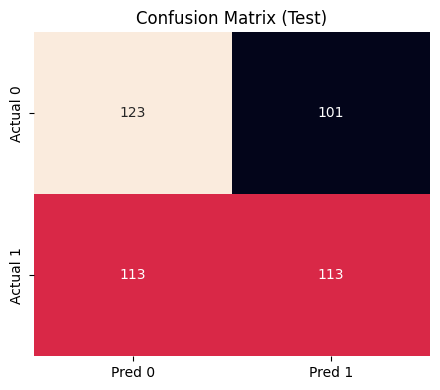

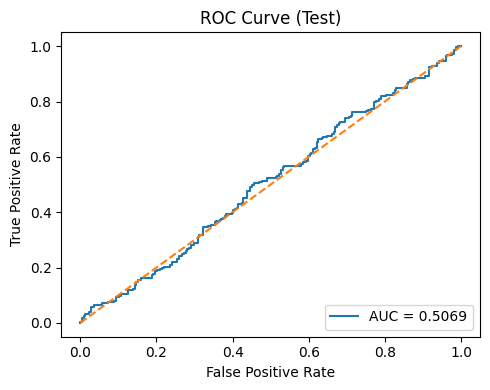


=== Top churn-INCREASING features (positive coefficients) ===
                           feature      coef
0   PaymentMethod_Electronic check  0.193058
1                   MonthlyCharges  0.109643
2               InternetService_No  0.076142
3               StreamingMovies_No  0.069637
4             DeviceProtection_Yes  0.068450
5                   StreamingTV_No  0.067409
6                           tenure  0.062752
7      PaymentMethod_Bank transfer  0.057569
8               OnlineSecurity_Yes  0.052714
9                Contract_One year  0.046947
10                  Dependents_Yes  0.045188
11                OnlineBackup_Yes  0.043353
12            PaperlessBilling_Yes  0.039944
13                   SeniorCitizen  0.039255
14                 TechSupport_Yes  0.036643

=== Top churn-DECREASING features (negative coefficients) ===
                                 feature      coef
0                           TotalCharges -0.177753
1             PaymentMethod_Mailed check -0.132366
2

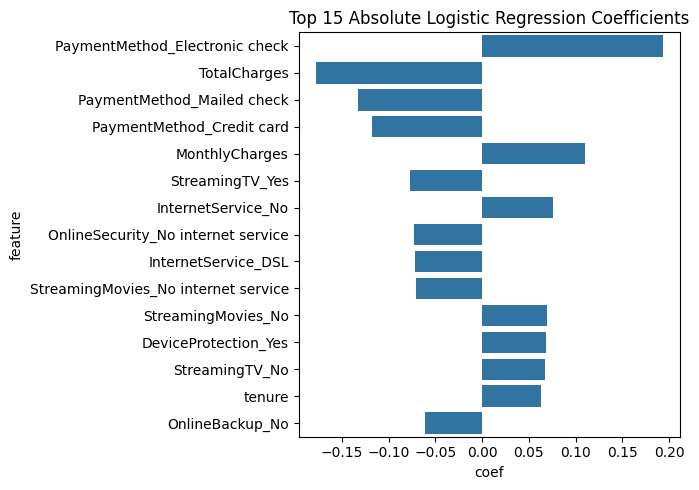


Saved:
 - reports/test_metrics_logreg.csv
 - reports/figures/confusion_matrix_test.png
 - reports/figures/roc_curve_test.png
 - reports/figures/top_features_by_coef.png

=== Top churn-INCREASING features (positive coefficients) ===
                           feature      coef
0   PaymentMethod_Electronic check  0.193058
1                   MonthlyCharges  0.109643
2               InternetService_No  0.076142
3               StreamingMovies_No  0.069637
4             DeviceProtection_Yes  0.068450
5                   StreamingTV_No  0.067409
6                           tenure  0.062752
7      PaymentMethod_Bank transfer  0.057569
8               OnlineSecurity_Yes  0.052714
9                Contract_One year  0.046947
10                  Dependents_Yes  0.045188
11                OnlineBackup_Yes  0.043353
12            PaperlessBilling_Yes  0.039944
13                   SeniorCitizen  0.039255
14                 TechSupport_Yes  0.036643

=== Top churn-DECREASING features (negative co

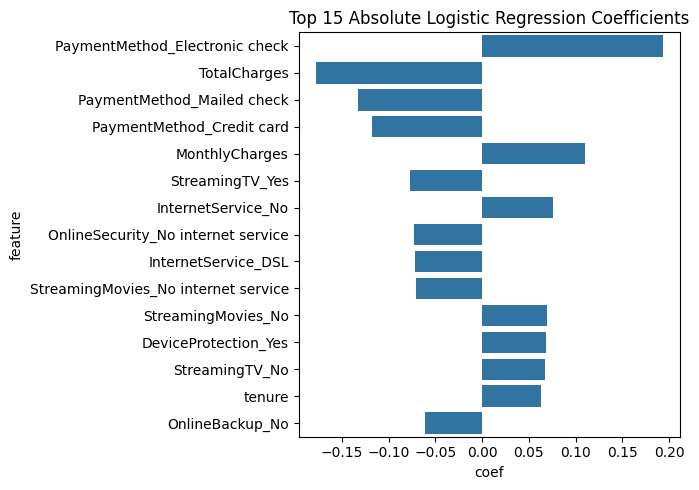


Saved:
 - reports/test_metrics_logreg.csv
 - reports/figures/confusion_matrix_test.png
 - reports/figures/roc_curve_test.png
 - reports/figures/top_features_by_coef.png


In [3]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

assert 'clf' in globals(), "Run the training cell first."
assert all(v in globals() for v in ['X_test', 'y_test']), "Missing X_test/y_test. Run the split cell first."

os.makedirs('reports/figures', exist_ok=True)
y_test_pred  = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

test_metrics = {
    'accuracy' : round(accuracy_score(y_test, y_test_pred), 4),
    'precision': round(precision_score(y_test, y_test_pred), 4),
    'recall'   : round(recall_score(y_test, y_test_pred), 4),
    'f1_score' : round(f1_score(y_test, y_test_pred), 4),
    'roc_auc'  : round(roc_auc_score(y_test, y_test_proba), 4)
}
print("\n=== Test Metrics ===")
for k, v in test_metrics.items():
    print(f"{k:>10}: {v}")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.savefig('reports/figures/confusion_matrix_test.png', dpi=150)
plt.show()
fpr, tpr, thr = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_metrics['roc_auc']}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('reports/figures/roc_curve_test.png', dpi=150)
plt.show()
prep  = clf.named_steps['preprocessor']
model = clf.named_steps['model']
num_names = num_cols
try:
    ohe = prep.named_transformers_['cat'].named_steps['ohe']
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
except Exception:
    cat_names = [f"{c}_<onehot>" for c in cat_cols]
feature_names = num_names + cat_names
coefs = model.coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
top_pos = coef_df.sort_values('coef', ascending=False).head(15).reset_index(drop=True)
top_neg = coef_df.sort_values('coef', ascending=True).head(15).reset_index(drop=True)
print("\n=== Top churn-INCREASING features (positive coefficients) ===")
print(top_pos)
print("\n=== Top churn-DECREASING features (negative coefficients) ===")
print(top_neg)
top_abs_idx = coef_df['coef'].abs().sort_values(ascending=False).head(15).index
top_abs = coef_df.loc[top_abs_idx]
plt.figure(figsize=(7, 5))
sns.barplot(x='coef', y='feature', data=top_abs)
plt.title('Top 15 Absolute Logistic Regression Coefficients')
plt.tight_layout()
plt.savefig('reports/figures/top_features_by_coef.png', dpi=150)
plt.show()
pd.Series(test_metrics).to_csv('reports/test_metrics_logreg.csv')
print("\nSaved:")
print(" - reports/test_metrics_logreg.csv")
print(" - reports/figures/confusion_matrix_test.png")
print(" - reports/figures/roc_curve_test.png")
print(" - reports/figures/top_features_by_coef.png")
coefs = model.coef_.ravel()
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
top_pos = coef_df.sort_values('coef', ascending=False).head(15).reset_index(drop=True)
top_neg = coef_df.sort_values('coef', ascending=True).head(15).reset_index(drop=True)
print("\n=== Top churn-INCREASING features (positive coefficients) ===")
print(top_pos)
print("\n=== Top churn-DECREASING features (negative coefficients) ===")
print(top_neg)
top_abs_idx = coef_df['coef'].abs().sort_values(ascending=False).head(15).index
top_abs = coef_df.loc[top_abs_idx]
plt.figure(figsize=(7, 5))
sns.barplot(x='coef', y='feature', data=top_abs)
plt.title('Top 15 Absolute Logistic Regression Coefficients')
plt.tight_layout()
plt.savefig('reports/figures/top_features_by_coef.png', dpi=150)
plt.show()
pd.Series(test_metrics).to_csv('reports/test_metrics_logreg.csv')
print("\nSaved:")
print(" - reports/test_metrics_logreg.csv")
print(" - reports/figures/confusion_matrix_test.png")
print(" - reports/figures/roc_curve_test.png")
print(" - reports/figures/top_features_by_coef.png")



In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
clf_bal = Pipeline(steps=[
    ('preprocessor', clf.named_steps['preprocessor']),
    ('model', LogisticRegression(max_iter=300, class_weight='balanced',n_jobs=None))])
clf_bal.fit(X_train, y_train)
y_val_pred  = clf_bal.predict(x_valid)
y_val_proba = clf_bal.predict_proba(x_valid)[:, 1]
print("\n=== balanced logistic(validation) ===")
print("accuracy:", round(accuracy_score(y_valid, y_val_pred), 4))
print("f1 score:", round(f1_score(y_valid, y_val_pred), 4))
print("roc auc score:", round(roc_auc_score(y_valid, y_val_proba), 4))
print("\nClassification report:\n", classification_report(y_valid, y_val_pred))



=== balanced logistic(validation) ===
accuracy: 0.5178
f1 score: 0.5252
roc auc score: 0.5151

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.50      0.51       225
           1       0.52      0.53      0.53       225

    accuracy                           0.52       450
   macro avg       0.52      0.52      0.52       450
weighted avg       0.52      0.52      0.52       450

